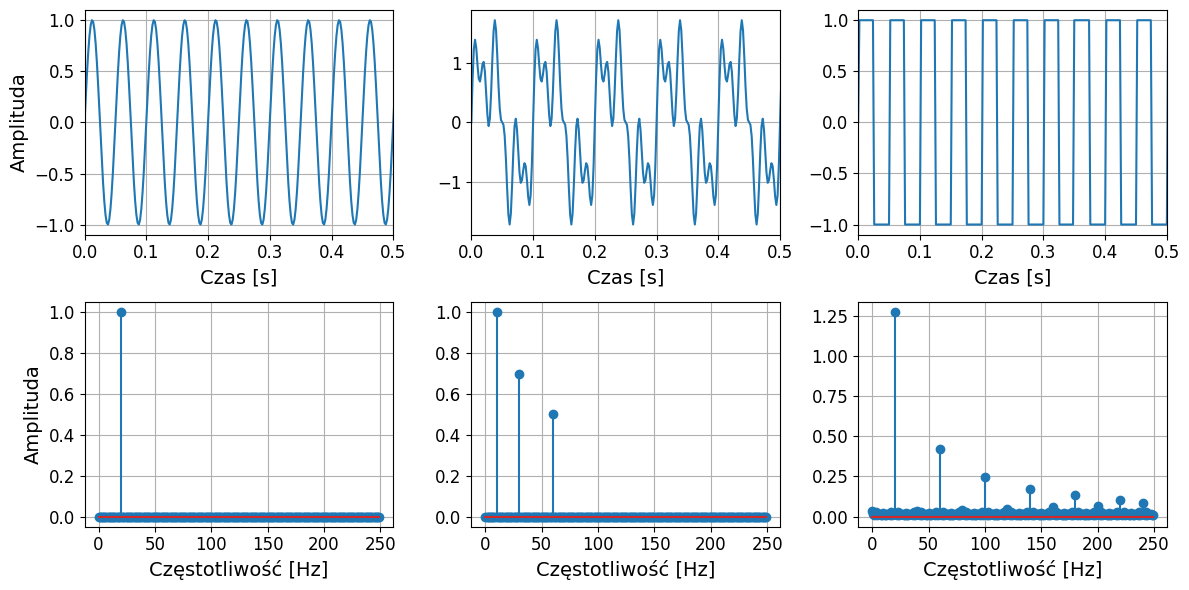

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry sygnałów
fs = 500        # częstotliwość próbkowania [Hz]
T = 1.0         # czas trwania [s]
t = np.linspace(0, T, int(fs*T), endpoint=False)

# 1) Sygnał sinusoidalny 20 Hz
x1 = np.sin(2 * np.pi * 20 * t)

# 2) Suma trzech różnych sinusów
x2 = (1.0 * np.sin(2 * np.pi * 10 * t) +
      0.7 * np.sin(2 * np.pi * 30 * t) +
      0.5 * np.sin(2 * np.pi * 60 * t))

# 3) Sygnał prostokątny 20 Hz
x3 = np.sign(np.sin(2 * np.pi * 20 * t))

def compute_fft(x, fs):
    N = len(x)
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=1.0/fs)
    idx = freqs >= 0
    freqs_pos = freqs[idx]
    X_amp = (2.0 / N) * np.abs(X[idx])
    return freqs_pos, X_amp

# Obliczenie widm
f1, X1 = compute_fft(x1, fs)
f2, X2 = compute_fft(x2, fs)
f3, X3 = compute_fft(x3, fs)

# Tworzenie wykresów 3x2
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Ustawienia czcionek
label_font = 14
tick_font = 12

# --------- 1. wiersz: sygnały w dziedzinie czasu ---------
# Ustal zakres czasu do wyświetlenia (np. 0–0.1 s)
time_window = (0, 0.5)

# Sinus 20 Hz
axes[0, 0].plot(t, x1)
axes[0, 0].set_xlim(time_window)
axes[0, 0].set_xlabel("Czas [s]", fontsize=label_font)
axes[0, 0].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 0].tick_params(labelsize=tick_font)
axes[0, 0].grid(True)

# Suma trzech sinusów
axes[0, 1].plot(t, x2)
axes[0, 1].set_xlim(time_window)
axes[0, 1].set_xlabel("Czas [s]", fontsize=label_font)
#axes[0, 1].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 1].tick_params(labelsize=tick_font)
axes[0, 1].grid(True)

# Prostokąt 20 Hz
axes[0, 2].plot(t, x3)
axes[0, 2].set_xlim(time_window)
axes[0, 2].set_xlabel("Czas [s]", fontsize=label_font)
#axes[0, 2].set_ylabel("Amplituda", fontsize=label_font)
axes[0, 2].tick_params(labelsize=tick_font)
axes[0, 2].grid(True)

# --------- 2. wiersz: widma częstotliwości ---------
f_max = 250

# Widmo sinusa 20 Hz
axes[1, 0].stem(f1[f1 <= f_max], X1[f1 <= f_max])
axes[1, 0].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
axes[1, 0].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 0].tick_params(labelsize=tick_font)
axes[1, 0].grid(True)

# Widmo sumy 3 sinusów
axes[1, 1].stem(f2[f2 <= f_max], X2[f2 <= f_max])
axes[1, 1].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
#axes[1, 1].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 1].tick_params(labelsize=tick_font)
axes[1, 1].grid(True)

# Widmo prostokąta 20 Hz
axes[1, 2].stem(f3[f3 <= f_max], X3[f3 <= f_max])
axes[1, 2].set_xlabel("Częstotliwość [Hz]", fontsize=label_font)
#axes[1, 2].set_ylabel("Amplituda", fontsize=label_font)
axes[1, 2].tick_params(labelsize=tick_font)
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()


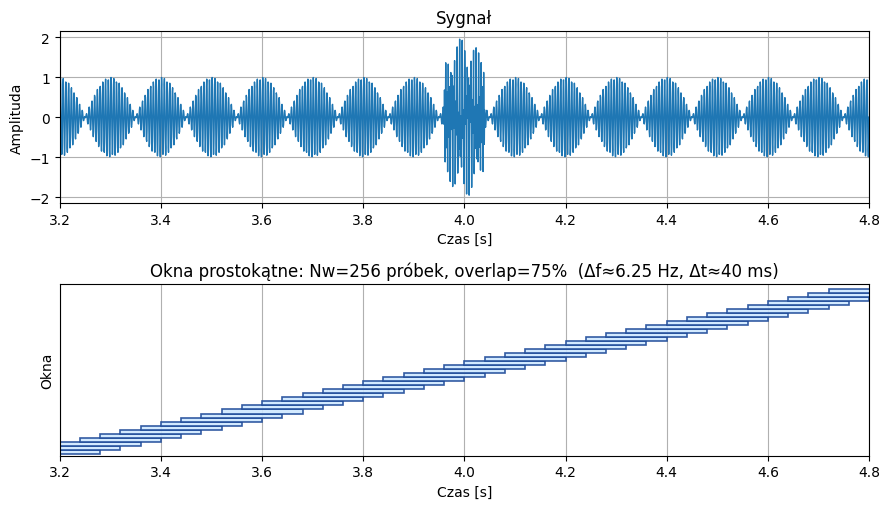

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- Parametry sygnału i STFT ---
fs = 1600.0               # [Hz]
T = 6.0                   # [s]
Nw = 256                  # długość okna [próbki] (krótkie okno)
overlap = 0.75            # nakładanie (75%)
hop = int(Nw * (1.0 - overlap))   # krok w próbkach
zoom_t0, zoom_t1 = 3.2, 4.8       # zakres zoomu [s]

# --- Generacja sygnału demo: 180/190 Hz + krótki burst 400 Hz ---
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst

# --- Wyznaczenie centrów okien, które mieszczą się w [zoom_t0, zoom_t1] ---
centers = []
n = max(Nw // 2, int(np.floor(zoom_t0 * fs / hop)) * hop)   # start tak, by okno było pełne
while (n - Nw//2) >= 0 and (n + Nw//2) < len(t) and (n/fs) <= zoom_t1:
    centers.append(n)
    n += hop
centers = np.array(centers, dtype=int)

# --- Rysunek: 2 subplota ---
fig, axes = plt.subplots(2, 1, figsize=(9, 5.2), sharex=False)

# (1) Sygnał w powiększeniu
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)
axes[0].plot(t[mask_zoom], x[mask_zoom], linewidth=1.0)
axes[0].set_xlim(zoom_t0, zoom_t1)
axes[0].set_title('Sygnał')
axes[0].set_xlabel('Czas [s]')
axes[0].set_ylabel('Amplituda')
axes[0].grid(True)

# (2) „Schodki” z prostokątnymi oknami (niebieskie wypełnienie + ciemnoniebieski kontur)
ax = axes[1]
for i, c in enumerate(centers):
    left = (c - Nw//2) / fs          # [s]
    width = Nw / fs                  # [s]
    rect = Rectangle(
        (left, i), width, 1.0,
        facecolor='#cfe8ff',   # jasny niebieski wypełnienia
        edgecolor='#1f4b99',   # ciemniejszy niebieski kontur
        alpha=0.9,             # delikatna przezroczystość (opcjonalnie)
        linewidth=1.2,
        zorder=2
    )
    ax.add_patch(rect)

ax.set_xlim(zoom_t0, zoom_t1)
ax.set_ylim(-0.5, len(centers) + 1.2)
ax.set_xlabel('Czas [s]')
ax.set_ylabel('Okna')
ax.set_yticks([])
df = fs / Nw
dt = hop / fs
ax.set_title(f'Okna prostokątne: Nw={Nw} próbek, overlap={int(overlap*100)}%  (Δf≈{df:.2f} Hz, Δt≈{dt*1000:.0f} ms)')
ax.grid(True, axis='x')

plt.tight_layout()
plt.show()


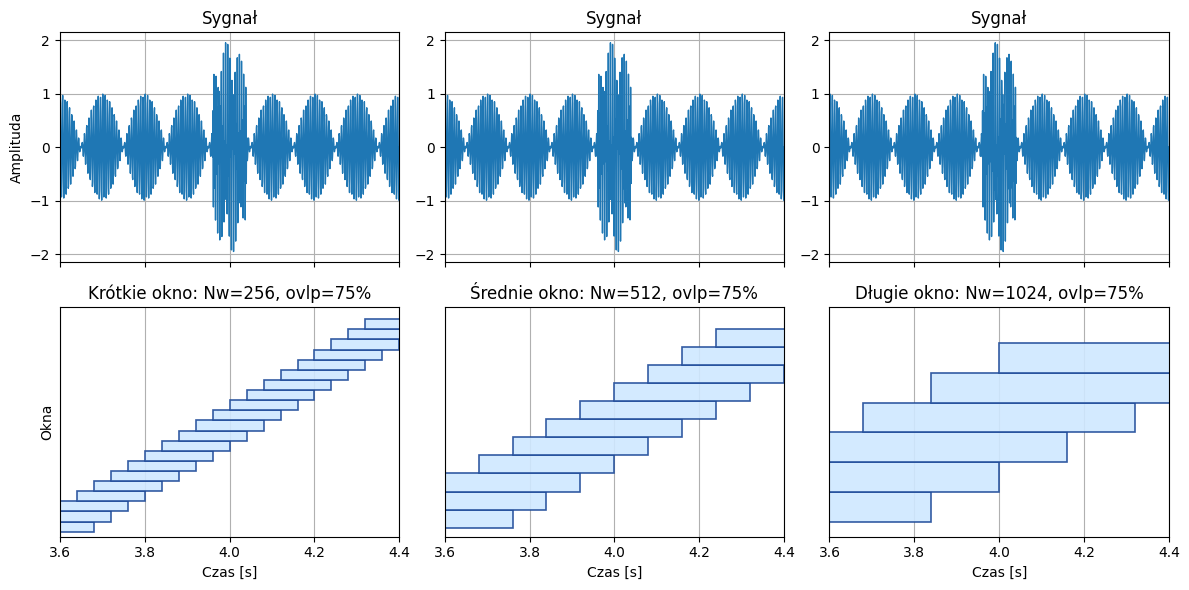

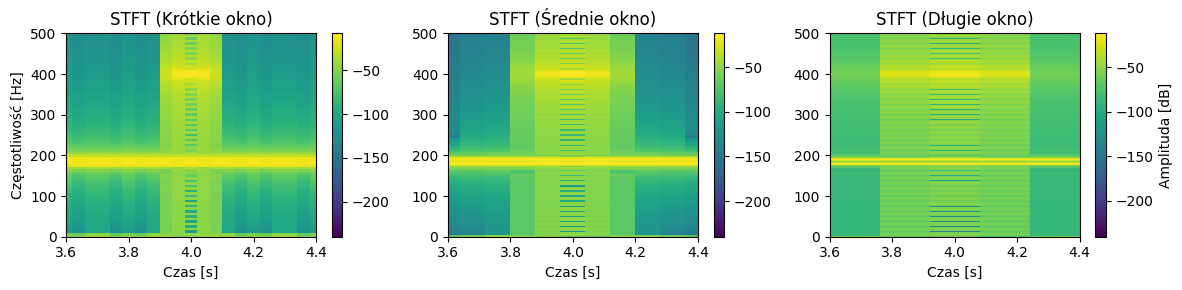

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import spectrogram, get_window

# --- Parametry globalne ---
fs = 1600.0
T  = 6.0
zoom_t0, zoom_t1 = 3.6, 4.4
overlap = 0.75  # 75%

# długości okien: krótkie / średnie / długie
Nw_short = 256
Nw_mid   = 512
Nw_long  = 1024

# --- sygnał demo: 180/190 Hz + krótki burst 400 Hz ---
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)

# --- pomocnicza: centra ramek w [zoom_t0, zoom_t1] ---
def compute_centers(Nw, overlap, t0, t1):
    hop = int(Nw * (1.0 - overlap))
    centers = []
    n = max(Nw // 2, int(np.floor(t0 * fs / hop)) * hop)
    while (n - Nw//2) >= 0 and (n + Nw//2) < len(t) and (n/fs) <= t1:
        centers.append(n)
        n += hop
    return np.array(centers, dtype=int), hop

# =========================================================
# FIGURA A: 2 x 3 (u góry sygnał; u dołu okna krótkie/średnie/długie)
# =========================================================
figA, axesA = plt.subplots(2, 3, figsize=(12, 6), sharex='col')

# Dane dla trzech kolumn
Nw_list   = [Nw_short, Nw_mid, Nw_long]
titles    = ['Krótkie okno', 'Średnie okno', 'Długie okno']

for j, (Nw, ttl) in enumerate(zip(Nw_list, titles)):
    # (góra) sygnał (zoom)
    axesA[0, j].plot(t[mask_zoom], x[mask_zoom], linewidth=1.0)
    axesA[0, j].set_title('Sygnał')
    axesA[0, j].grid(True)
    axesA[0, j].set_xlim(zoom_t0, zoom_t1)
    if j == 0:
        axesA[0, j].set_ylabel('Amplituda')

    # (dół) schodki z prostokątnymi oknami
    centers, hop = compute_centers(Nw, overlap, zoom_t0, zoom_t1)
    ax = axesA[1, j]
    for i, c in enumerate(centers):
        left  = (c - Nw//2) / fs
        width = Nw / fs
        rect = Rectangle(
            (left, i), width, 1.0,
            facecolor='#cfe8ff', edgecolor='#1f4b99',
            alpha=0.9, linewidth=1.2, zorder=2
        )
        ax.add_patch(rect)

    ax.set_xlim(zoom_t0, zoom_t1)
    ax.set_ylim(-0.5, len(centers) + 1.2)
    ax.set_yticks([])
    df = fs / Nw
    dt = hop / fs
    ax.set_title(f'{ttl}: Nw={Nw}, ovlp=75%')
    ax.set_xlabel('Czas [s]')
    if j == 0:
        ax.set_ylabel('Okna')
    ax.grid(True, axis='x')

plt.tight_layout()
plt.show()

# =========================================================
# FIGURA B: 1 x 3 (STFT dla krótkiego / średniego / długiego okna)
# =========================================================
figB, axesB = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

for j, (Nw, ttl) in enumerate(zip(Nw_list, titles)):
    win = get_window('hann', Nw, fftbins=True)
    f, tt, S = spectrogram(x, fs=fs, window=win, nperseg=Nw,
                           noverlap=int(Nw*overlap), scaling='spectrum', mode='magnitude')
    S_db = 20*np.log10(S + 1e-12)
    im = axesB[j].pcolormesh(tt, f, S_db, shading='auto')
    axesB[j].set_ylim(0, 500)
    axesB[j].set_xlim(zoom_t0, zoom_t1)
    axesB[j].set_title(f'STFT ({ttl})')
    axesB[j].set_xlabel('Czas [s]')
    if j == 0:
        axesB[j].set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=axesB[j])
    if j == 2:
        cbar.set_label('Amplituda [dB]')

plt.tight_layout()
plt.show()


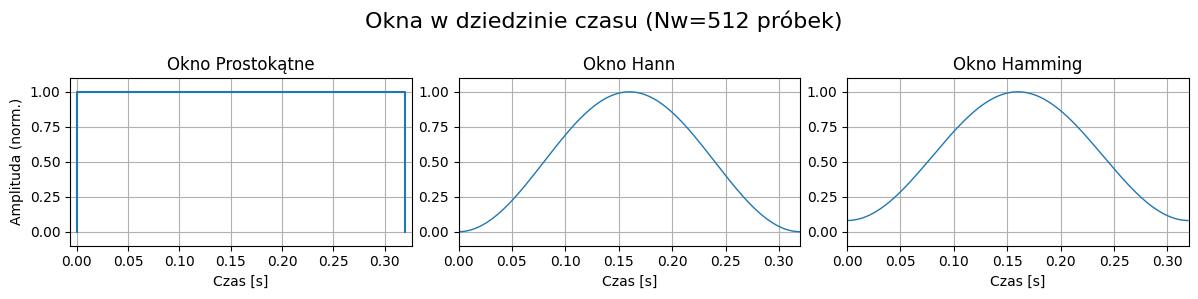

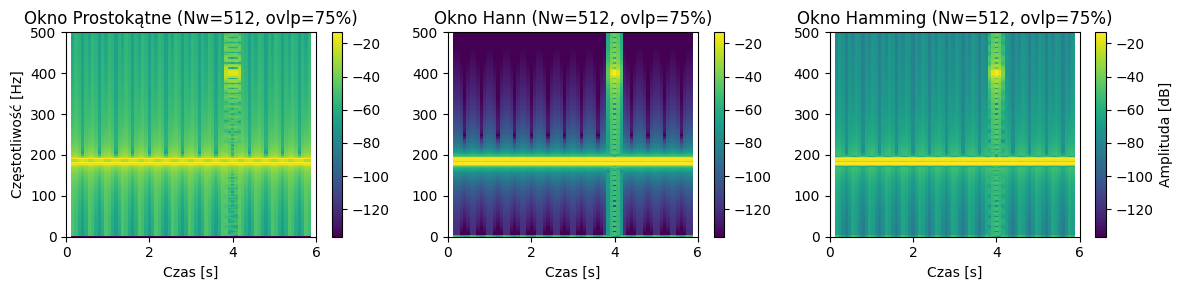

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, spectrogram

# ===================== USTAWIENIA =====================
fs = 1600.0                 # [Hz]
T  = 6.0                    # [s]
overlap = 0.75              # 75% dla STFT
zoom_t0, zoom_t1 = 0, 6 # zakres czasu na wykresach
Nw = 512                    # stała długość okna dla porównań

# Okna do porównania (etykieta, klucz w get_window)
windows = [
    ('Prostokątne', 'boxcar'),
    ('Hann',        'hann'),
    ('Hamming',     'hamming'),
]

# ===================== SYGNAŁ DEMO =====================
t = np.arange(0, T, 1.0/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst
mask_zoom = (t >= zoom_t0) & (t <= zoom_t1)

# ===================== FIGURA A: 1×3 – OKNA W DZIEDZINIE CZASU =====================
figA, axesA = plt.subplots(1, 3, figsize=(12, 3), sharex=False)
figA.suptitle('Okna w dziedzinie czasu (Nw=512 próbek)', fontsize=16)

for j, (label, key) in enumerate(windows):
    ax = axesA[j]
    if key == 'boxcar':
        # PRZEBIEG PROSTOKĄTNY: poziom 0 → 1 → 1 → 0 z wyraźnymi krawędziami
        dur = Nw / fs
        x_step = [0.0, 0.0, dur,  dur]   # czas
        y_step = [0.0, 1.0, 1.0, 0.0]    # amplituda
        ax.plot(x_step, y_step, linewidth=1.5, drawstyle='default')
        ax.set_xlim(-0.02*dur, 1.02*dur)
        ax.set_ylim(-0.1, 1.1)
    else:
        # Hann / Hamming – przebieg próbki po próbce (znormalizowany do 1)
        w = get_window(key, Nw, fftbins=True).astype(float)
        w = w / (np.max(np.abs(w)) + 1e-12)
        n = np.arange(Nw) / fs
        ax.plot(n, w, linewidth=1.0)
        ax.set_xlim(0, Nw/fs)
        ax.set_ylim(-0.1, 1.1)

    ax.set_title(f'Okno {label}')
    ax.set_xlabel('Czas [s]')
    if j == 0:
        ax.set_ylabel('Amplituda (norm.)')
    ax.grid(True)

plt.tight_layout()
plt.show()

# ===================== FIGURA B: 1×3 – SPEKTROGRAMY (Nw=512, różne okna) =====================
figB, axesB = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

# Najpierw policzmy wspólny zakres dB (vmin/vmax) dla uczciwego porównania
specs = []
for label, key in windows:
    win = get_window(key, Nw, fftbins=True)
    f, tt, S = spectrogram(x, fs=fs, window=win, nperseg=Nw,
                           noverlap=int(Nw*overlap), scaling='spectrum', mode='magnitude')
    specs.append((label, f, tt, 20*np.log10(S + 1e-12)))

vals = []
for _, f, tt, S_db in specs:
    fmask = (f >= 0) & (f <= 500)
    tmask = (tt >= zoom_t0) & (tt <= zoom_t1)
    vals.append(S_db[np.ix_(fmask, tmask)])
all_vals = np.concatenate([v.ravel() for v in vals])
vmin = np.percentile(all_vals, 5)
vmax = np.percentile(all_vals, 99)

for ax, (label, f, tt, S_db) in zip(axesB, specs):
    im = ax.pcolormesh(tt, f, S_db, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_ylim(0, 500)
    ax.set_xlim(zoom_t0, zoom_t1)
    ax.set_title(f'Okno {label} (Nw={Nw}, ovlp=75%)')
    ax.set_xlabel('Czas [s]')
    if ax is axesB[0]:
        ax.set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=ax)
    if ax is axesB[2]:
        cbar.set_label('Amplituda [dB]')
    

plt.tight_layout()
plt.show()


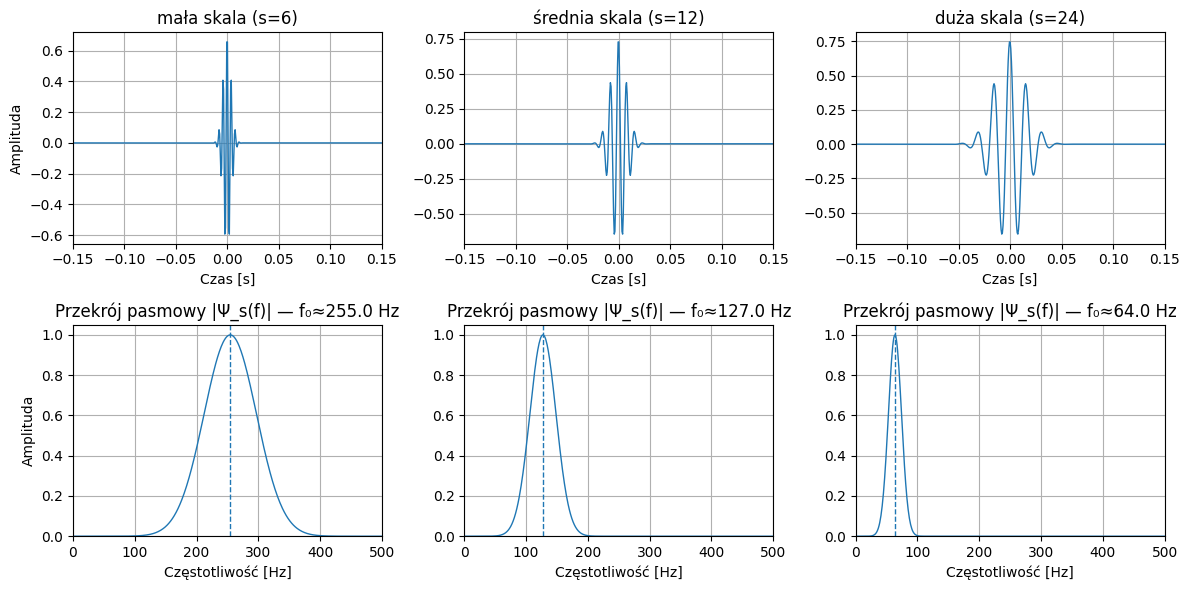

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

# ========= kompatybilny zamiennik morlet2 (zespolona falka Morleta) =========
def morlet_complex(M, s, w=6.0):
    """
    M - liczba próbek okna rysowania
    s - skala (odchylenie Gaussa) w PRÓBKACH
    w - liczba oscylacji pod obwiednią (typowo 5–8)
    Zwraca: kompleksowa falka Morleta wycentrowana w czasie (mean≈0).
    """
    n = np.arange(M) - (M - 1)/2
    t = n / s
    C = np.pi**(-0.25)
    psi = C * np.exp(1j*w*t) * np.exp(-0.5*t**2)
    psi -= psi.mean()  # „complete=True”: usunięcie składowej stałej
    return psi

# ===================== parametry wykresu =====================
fs = 1600.0   # [Hz]
T  = 1.0      # [s] czas okna rysowania (dla jasnej prezentacji)
M  = int(T*fs)
t  = np.arange(M)/fs - T/2  # oś czasu wycentrowana

w = 6.0  # parametr Morleta (liczba oscylacji pod obwiednią)

# Trzy skale: mała (wysokie f), średnia, duża (niskie f)
s_small = 6
s_mid   = 12
s_large = 24

# Falka (część rzeczywista do rysunku czasowego)
psi_small = morlet_complex(M, s_small, w=w)
psi_mid   = morlet_complex(M, s_mid,   w=w)
psi_large = morlet_complex(M, s_large, w=w)

# Widma (moduł, znormalizowane), oś częstotliwości
f_axis = rfftfreq(M, d=1/fs)
F_small = np.abs(rfft(psi_small)); F_small /= F_small.max() + 1e-12
F_mid   = np.abs(rfft(psi_mid));   F_mid   /= F_mid.max()   + 1e-12
F_large = np.abs(rfft(psi_large)); F_large /= F_large.max() + 1e-12

# Częstotliwości „środkowe” (pozycja maksimum w widmie)
f0_small = f_axis[np.argmax(F_small)]
f0_mid   = f_axis[np.argmax(F_mid)]
f0_large = f_axis[np.argmax(F_large)]

# ===================== rysunek 2×3 =====================
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=False)
#fig.suptitle('Falka Morleta: różne skale (s)', fontsize=16)

# ---- górny rząd: falki w czasie (Re) ----
axes[0,0].plot(t, np.real(psi_small), linewidth=1.0)
axes[0,0].set_title(f'mała skala (s={s_small})')
axes[0,0].set_xlabel('Czas [s]'); axes[0,0].set_ylabel('Amplituda')
axes[0,0].grid(True)
axes[0,0].set_xlim(-0.15, 0.15)

axes[0,1].plot(t, np.real(psi_mid), linewidth=1.0)
axes[0,1].set_title(f'średnia skala (s={s_mid})')
axes[0,1].set_xlabel('Czas [s]'); axes[0,1].grid(True)
axes[0,1].set_xlim(-0.15, 0.15)

axes[0,2].plot(t, np.real(psi_large), linewidth=1.0)
axes[0,2].set_title(f'duża skala (s={s_large})')
axes[0,2].set_xlabel('Czas [s]'); axes[0,2].grid(True)
axes[0,2].set_xlim(-0.15, 0.15)

# ---- dolny rząd: przekroje pasmowe (|Ψ_s(f)|, skala liniowa, norm. do 1) ----
ylim = (0, 1.05)
xlim = (0, 500)  # pasmo istotne do demonstracji

axes[1,0].plot(f_axis, F_small, linewidth=1.0)
axes[1,0].axvline(f0_small, linestyle='--', linewidth=1.0)
axes[1,0].set_xlim(*xlim); axes[1,0].set_ylim(*ylim)
axes[1,0].set_title(f'Przekrój pasmowy |Ψ_s(f)| — f₀≈{f0_small:.1f} Hz')
axes[1,0].set_xlabel('Częstotliwość [Hz]'); axes[1,0].set_ylabel('Amplituda')
axes[1,0].grid(True)

axes[1,1].plot(f_axis, F_mid, linewidth=1.0)
axes[1,1].axvline(f0_mid, linestyle='--', linewidth=1.0)
axes[1,1].set_xlim(*xlim); axes[1,1].set_ylim(*ylim)
axes[1,1].set_title(f'Przekrój pasmowy |Ψ_s(f)| — f₀≈{f0_mid:.1f} Hz')
axes[1,1].set_xlabel('Częstotliwość [Hz]'); axes[1,1].grid(True)

axes[1,2].plot(f_axis, F_large, linewidth=1.0)
axes[1,2].axvline(f0_large, linestyle='--', linewidth=1.0)
axes[1,2].set_xlim(*xlim); axes[1,2].set_ylim(*ylim)
axes[1,2].set_title(f'Przekrój pasmowy |Ψ_s(f)| — f₀≈{f0_large:.1f} Hz')
axes[1,2].set_xlabel('Częstotliwość [Hz]'); axes[1,2].grid(True)

plt.tight_layout()
plt.show()


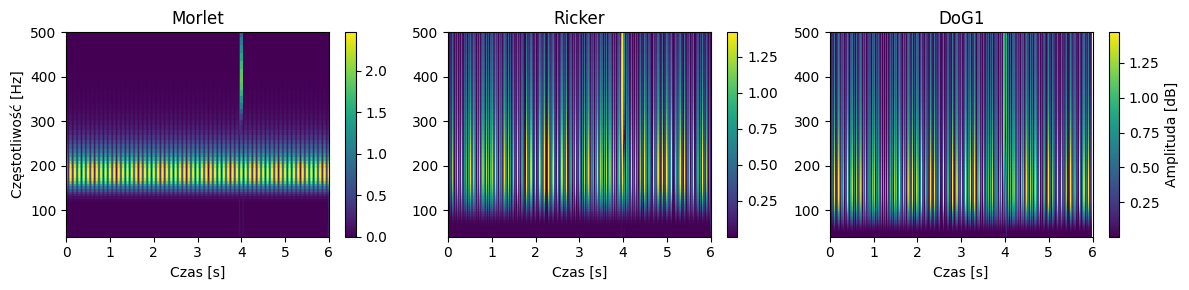

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from scipy.signal import fftconvolve

# ---------- FALKI (generatory w dziedzinie czasu, skala s = "szerokość" w próbkach) ----------
def wavelet_morlet(M, s, w=6.0):
    n = np.arange(M) - (M - 1)/2
    t = n / s
    C = np.pi**(-0.25)
    psi = C * np.exp(1j*w*t) * np.exp(-0.5*t**2)
    psi -= psi.mean()  # "complete=True" -> usunięcie DC
    return psi

def wavelet_ricker(M, s):
    # Mexican hat / Ricker (realna), zgodna skala: s ~ sigma Gaussa
    n = np.arange(M) - (M - 1)/2
    t = n / s
    A = 2 / (np.sqrt(3*s) * np.pi**0.25)  # standardowa normalizacja (nie krytyczna do porównań)
    psi = A * (1 - t**2) * np.exp(-0.5*t**2)
    psi -= psi.mean()
    return psi

def wavelet_dog1(M, s):
    # 1. pochodna Gaussa (realna, antysymetryczna)
    n = np.arange(M) - (M - 1)/2
    t = n / s
    C = (2/np.sqrt(3)) * (1/np.pi**0.25)  # stała skali nie jest krytyczna
    psi = -C * t * np.exp(-0.5*t**2)
    psi -= psi.mean()
    return psi

# ---------- Pomocniczo: wyznacz "f0_norm" (częstotliwość środkowa dla s=1, dt=1) ----------
def center_frequency_constant(wavelet_fn, *, w_param=None, M=4096):
    psi = wavelet_fn(M, s=1.0, **({'w': w_param} if w_param is not None else {}))
    # FFT przy fs_ref = 1 Hz => oś częstotliwości to "cykle na próbkę" * 1 Hz
    F = np.abs(rfft(psi))
    freqs = rfftfreq(M, d=1.0)  # Nyquist = 0.5
    k = freqs[np.argmax(F)]      # "częstotliwość środkowa" dla s=1, dt=1
    return k  # [Hz] przy dt=1 s/próbkę

# ---------- Sygnał (jak w STFT) ----------
fs = 1600.0
T  = 6.0
t  = np.arange(0, T, 1/fs)
x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst = ((t >= 4.0-0.04) & (t <= 4.0+0.04)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * burst

# ---------- Siatka częstotliwości (wspólna dla wszystkich falek) ----------
fmin, fmax = 40.0, 500.0
n_scales = 64
f_grid = np.geomspace(fmin, fmax, n_scales)
dt = 1.0/fs

# ---------- Wyznacz k = f0_norm dla każdej rodziny i policz CWT ----------
families = [
    ('Morlet', wavelet_morlet, {'w_param': 6, 'label': 'morlet'}),
    ('Ricker', wavelet_ricker, {'w_param': None, 'label': 'ricker'}),
    ('DoG1', wavelet_dog1,   {'w_param': None, 'label': 'dog1'}),
]

results = []  # (title, f_grid, |C|)

for title, wfn, meta in families:
    if meta['label'] == 'morlet':
        k = meta['w_param'] / (2*np.pi)  # f0 dla s=1, dt=1 (analitycznie)
    else:
        k = center_frequency_constant(wfn, w_param=meta['w_param'])
    s_grid = k / (f_grid * dt)  # s(f) ~ k / (f * dt)

    M = t.size
    C = np.empty((n_scales, M), dtype=complex)
    for i, s in enumerate(s_grid):
        if meta['label'] == 'morlet':
            psi = wfn(M, s, w=meta['w_param'])
        else:
            psi = wfn(M, s)
        # korelacja (CWT) – konwencjonalnie dzielimy przez sqrt(s) dla stabilnej energii
        C[i, :] = fftconvolve(x, psi[::-1].conj(), mode='same') / np.sqrt(s)
    results.append((title, f_grid.copy(), np.abs(C)))

# ---------- Wspólna skala kolorów (percentyle z całego zestawu) ----------
#vals = np.concatenate([R[2].ravel() for R in results])
vmin = np.percentile(vals, 5)
vmax = np.percentile(vals, 99)

# ---------- Rysunek 1×3 ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)
for ax, (title, f_axis, S) in zip(axes, results):
    vmin = np.percentile(S, 5)     # per-panel
    vmax = np.percentile(S, 99)
    im = ax.pcolormesh(t, f_axis, S, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_ylim(fmin, fmax)
    ax.set_xlim(0, T)
    ax.set_title(f'{title}')
    ax.set_xlabel('Czas [s]')
    if ax is axes[0]:
        ax.set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=ax)
    if ax is axes[2]:
        cbar.set_label('Amplituda [dB]')


plt.tight_layout()
plt.show()


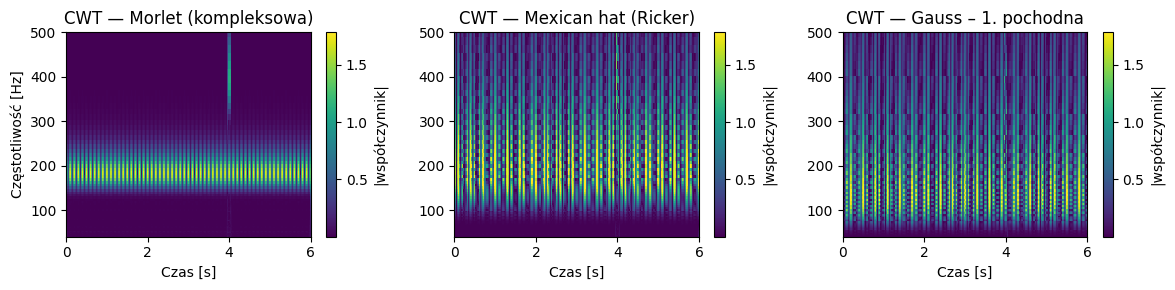

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# --- sygnał jak w STFT-demo ---
fs = 1600.0
T  = 6.0
t  = np.arange(0, T, 1/fs)
x  = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst = ((t >= 4.0-0.04) & (t <= 4.0+0.04)).astype(float)
x    += 1.0*np.sin(2*np.pi*400.0*t) * burst
dt = 1/fs

# --- siatka CZĘSTOTLIWOŚCI (wspólna dla wszystkich) i mapowanie -> scale ---
fmin, fmax = 40.0, 500.0
n_scales = 64
f_grid = np.geomspace(fmin, fmax, n_scales)  # Hz

def freqs_to_scales(wavelet: str, freqs_hz: np.ndarray, dt: float) -> np.ndarray:
    """
    PyWavelets: scale2frequency(wavelet, scale)/dt = frequency [Hz]
    => scale = central_frequency(wavelet)/(freq*dt)
    """
    f0 = pywt.central_frequency(wavelet)   # częstotliwość centralna falki dla scale=1
    return f0 / (freqs_hz * dt)

# --- trzy rodziny falek ---
waves = [
    ("Morlet (kompleksowa)", "cmor1.0-1.5"),  # cmorB-C: B=bandwidth, C=center (parametry możesz stroić)
    ("Mexican hat (Ricker)", "mexh"),
    ("Gauss – 1. pochodna", "gaus1"),
]

# --- licz CWT i rysuj 1×3 ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

# najpierw policzemy wszystkie, by ustalić wspólną skalę kolorów (opcjonalnie)
coef_maps = []
for title, wname in waves:
    scales = freqs_to_scales(wname, f_grid, dt)
    coef, freqs = pywt.cwt(x, scales=scales, wavelet=wname, sampling_period=dt)  # coef: [n_scales, N]
    coef_maps.append((title, np.abs(coef)))

# wspólny zakres kolorów (uczciwe porównanie)
vals = np.concatenate([C.ravel() for _, C in coef_maps])
vmin, vmax = np.percentile(vals, 5), np.percentile(vals, 99)

# rysunek
for ax, ((title, wname), (_, Cabs)) in zip(axes, zip(waves, coef_maps)):
    im = ax.pcolormesh(t, f_grid, Cabs, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_ylim(fmin, fmax); ax.set_xlim(0, T)
    ax.set_title(f'CWT — {title}')
    ax.set_xlabel('Czas [s]')
    if ax is axes[0]:
        ax.set_ylabel('Częstotliwość [Hz]')
    cbar = plt.colorbar(im, ax=ax); cbar.set_label('|współczynnik|')

plt.tight_layout(); plt.show()


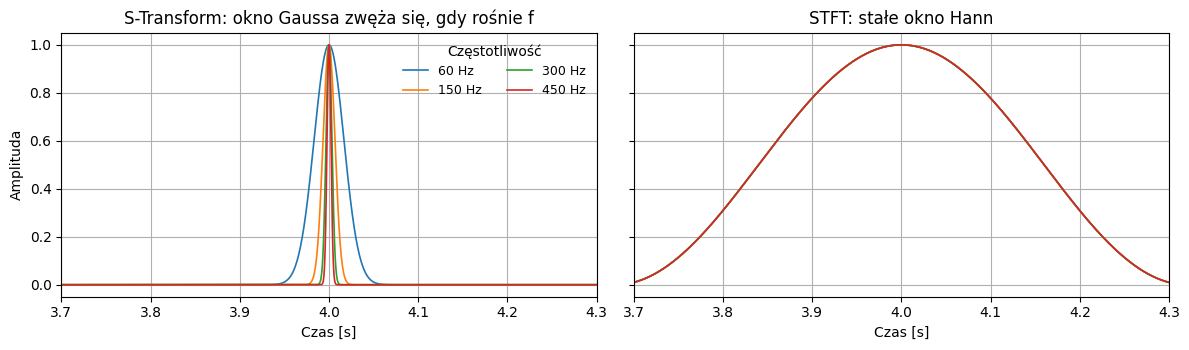

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# --- ustawienia osi czasu ---
fs   = 1600.0        # Hz (spójnie z resztą rozdziału)
tau  = 4.0           # [s] położenie okna (środek) na osi czasu
tmin, tmax = 3.7, 4.3
t = np.arange(tmin, tmax, 1/fs)

# --- częstotliwości do porównania (te same po obu stronach) ---
freqs = [60, 150, 300, 450]  # Hz

# --- (A) S-Transform: okno Gaussa zależne od częstotliwości ---
# z definicji ST:  |f|/sqrt(2π) * exp(-(t-τ)^2 * f^2 / 2)
def s_window(t, tau, f):
    g = np.abs(f) * np.exp(-0.5 * ((t - tau) * f)**2)  # stała 1/sqrt(2π) nie ma znaczenia dla kształtu
    return g / (g.max() + 1e-12)  # normalizacja do 1 dla równej skali

# --- (B) STFT: stałe okno Hann (ta sama długość dla wszystkich f) ---
# dobierzmy długość tak, aby porównanie było wizualne; np. 1024 próbek przy fs=1600 Hz (~0.64 s)
Nw = 1024
def hann_window(t, tau, Nw, fs):
    width = Nw / fs
    x = (t - tau) / (width/2)  # -1..1
    w = 0.5 * (1 + np.cos(np.pi * x))
    w[np.abs(x) > 1] = 0.0
    return w

# --- rysunek 1×2 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3.6), sharey=True)

# panel (A): S-Transform – okna w funkcji f
for f in freqs:
    axes[0].plot(t, s_window(t, tau, f), label=f'{f} Hz', linewidth=1.2)
axes[0].set_title('S-Transform: okno Gaussa zwęża się, gdy rośnie f')
axes[0].set_xlabel('Czas [s]'); axes[0].set_ylabel('Amplituda')
axes[0].set_xlim(tmin, tmax); axes[0].grid(True)
axes[0].legend(title='Częstotliwość', ncols=2, fontsize=9, frameon=False)

# panel (B): STFT – jedno, stałe okno dla wszystkich f
w_hann = hann_window(t, tau, Nw, fs)
for f in freqs:
    axes[1].plot(t, w_hann, linewidth=1.2)  # taki sam kształt dla każdego f
axes[1].set_title(f'STFT: stałe okno Hann')
axes[1].set_xlabel('Czas [s]'); axes[1].set_xlim(tmin, tmax)
axes[1].grid(True)

plt.tight_layout()
plt.show()


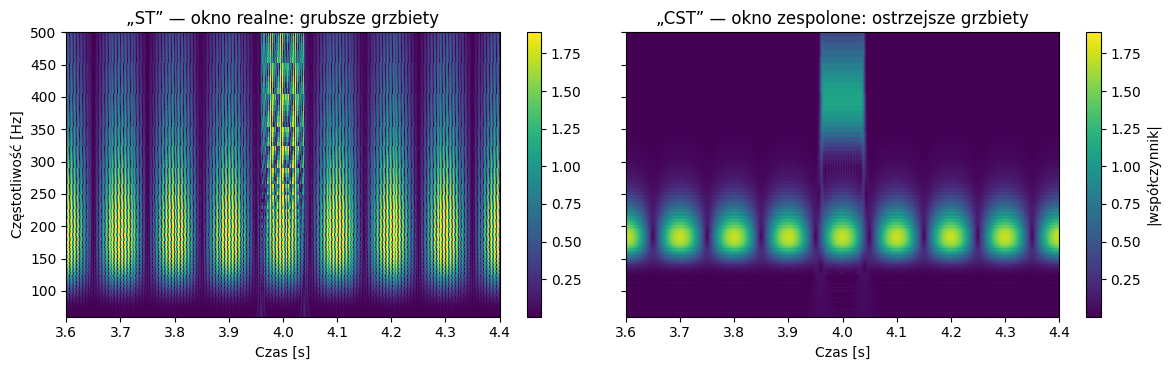

In [ ]:
# pip install PyWavelets
import numpy as np
import matplotlib.pyplot as plt
import pywt

# ========= sygnał jak w części STFT (dwie bliskie składowe + krótki burst) =========
fs = 1600.0
T  = 6.0
t  = np.arange(0, T, 1/fs)

x = 0.5*np.sin(2*np.pi*180.0*t) + 0.5*np.sin(2*np.pi*190.0*t)
burst_center, burst_dur = 4.0, 0.08
mask_burst = ((t >= burst_center - burst_dur/2) & (t <= burst_center + burst_dur/2)).astype(float)
x += 1.0*np.sin(2*np.pi*400.0*t) * mask_burst
dt = 1/fs

# ========= wspólna siatka częstotliwości i mapowanie na skale =========
fmin, fmax = 60.0, 500.0
n_scales = 96
f_grid = np.geomspace(fmin, fmax, n_scales)   # [Hz]

def freqs_to_scales(wavelet: str, freqs_hz: np.ndarray, dt: float) -> np.ndarray:
    # PyWavelets: freq = central_frequency(wavelet)/scale / dt
    f0 = pywt.central_frequency(wavelet)
    return f0 / (freqs_hz * dt)

# Realne „okno” (proxy ST) – mexican hat
w_real = "mexh"
scales_real = freqs_to_scales(w_real, f_grid, dt)
coef_real, _ = pywt.cwt(x, scales=scales_real, wavelet=w_real, sampling_period=dt)
A_real = np.abs(coef_real)

# Zespolone „okno” (proxy CST) – complex Morlet; parametry B-C można dostrajać
w_cmplx = "cmor1.0-1.5"   # (bandwidth=1.0, center=1.5) – do korekty jeśli chcesz jeszcze ostrzej
scales_cmplx = freqs_to_scales(w_cmplx, f_grid, dt)
coef_cmplx, _ = pywt.cwt(x, scales=scales_cmplx, wavelet=w_cmplx, sampling_period=dt)
A_cmplx = np.abs(coef_cmplx)

# ========= fragment mapy TF (zoom w okolicach zdarzenia) =========
t0, t1 = 3.6, 4.4
mask_t = (t >= t0) & (t <= t1)

# Wspólna skala kolorów (percentyle z obu map)
vals = np.concatenate([A_real[:, mask_t].ravel(), A_cmplx[:, mask_t].ravel()])
vmin, vmax = np.percentile(vals, 5), np.percentile(vals, 99)

# ========= rysunek 1×2: ST (real) vs CST (complex) =========
fig, axes = plt.subplots(1, 2, figsize=(12, 3.8), sharey=True)

im0 = axes[0].pcolormesh(t[mask_t], f_grid, A_real[:, mask_t],
                         shading='auto', vmin=vmin, vmax=vmax)
axes[0].set_title('„ST” — okno realne: grubsze grzbiety')
axes[0].set_xlabel('Czas [s]'); axes[0].set_ylabel('Częstotliwość [Hz]')
axes[0].set_ylim(fmin, fmax)
cbar0 = plt.colorbar(im0, ax=axes[0])

im1 = axes[1].pcolormesh(t[mask_t], f_grid, A_cmplx[:, mask_t],
                         shading='auto', vmin=vmin, vmax=vmax)
axes[1].set_title('„CST” — okno zespolone: ostrzejsze grzbiety')
axes[1].set_xlabel('Czas [s]'); axes[1].set_ylim(fmin, fmax)
cbar1 = plt.colorbar(im1, ax=axes[1]); cbar1.set_label('|współczynnik|')

plt.tight_layout(); plt.show()

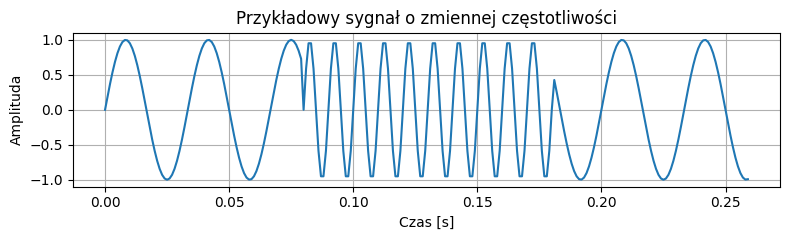

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Parametry sygnału
Fs = 1000.0           # częstotliwość próbkowania [Hz]
T = 0.26              # czas trwania [s]
t = np.arange(0, T, 1/Fs)

# Wolna sinusoidę (np. 10 Hz) aktywna w środkowej części
slow_freq = 100.0
slow_mask = (t >= 0.08) & (t <= 0.18)
slow = np.sin(2*np.pi*slow_freq*t) * slow_mask

# Szybka sinusoidę (np. 40 Hz) aktywna na początku i na końcu
fast_freq = 30.0
fast_mask = (t < 0.08) | (t > 0.18)
fast = np.sin(2*np.pi*fast_freq*t) * fast_mask

# Sygnał złożony
y = slow + fast

# Podgląd sygnału złożonego (opcjonalnie)
plt.figure(figsize=(8, 2.5))
plt.plot(t, y)
plt.grid()
plt.xlabel("Czas [s]")
plt.ylabel("Amplituda")
plt.title("Przykładowy sygnał o zmiennej częstotliwości")
plt.tight_layout()
plt.show()


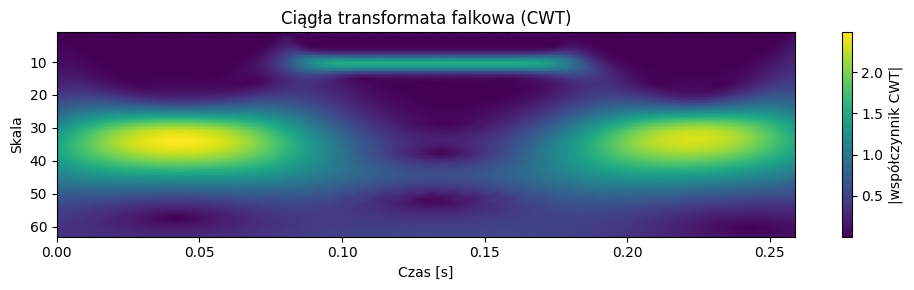

In [18]:
# 3. Definicja skal i falki
#    Skale: od 1 do 64 (im mniejsza skala, tym wyższa częstotliwość)
scales = np.arange(1, 64)

# Falkę wybieramy zespoloną Morleta (możesz zmienić na inną)
wavelet = "cmor1.5-1.0"

# 4. Liczenie CWT
coeffs, freqs = pywt.cwt(y, scales, wavelet, sampling_period=1.0/Fs)
# coeffs: shape = (n_scales, n_time)

# 5. Moduł współczynników (amplituda)
power = np.abs(coeffs)

# 6. Rysowanie skalogramu: oś Y = SKALA
plt.figure(figsize=(10, 3))

# extent = [czas_początek, czas_koniec, skala_max, skala_min]
# odwracamy oś, żeby skala 1 była na górze (wysoka częstotliwość)
plt.imshow(
    power,
    extent=[t[0], t[-1], scales[-1], scales[0]],
    aspect='auto',
    origin='upper'
)

plt.colorbar(label="|współczynnik CWT|")
plt.xlabel("Czas [s]")
plt.ylabel("Skala")
plt.title("Ciągła transformata falkowa (CWT)")
plt.tight_layout()
plt.show()
